# Predicting Future Population Count

---

<div class="alert alert-block alert-success">
    
## Summary:

### - This project I wanted to veer into predicting the population by country. There are multiple datasets within https://www.kaggle.com/datasets/census/international-data?select=midyear_population_age_country_code.csv with varying features, but ended on a fairly straight-forward approach on world population based on the past 70 years of data. The data I'm working with predicts up until 2050 itself, so that is the data that is split.
    
### The best prediction model (Holt's Optimized) does well with validate, but less so with the test sample.

---

## Project Goal

- Predict future world population
    
## Project Planning

1. Acquire from .csv
    - Peer through datasets
    - Sift through files and find relevant data
2. Prepare
    - Find associated data and potentially merge files
3. Explore
    - Look for additional insights
4. Model
    - Find the best Model
5. Report Findings

---

## Imports:

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats
from math import sqrt 

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling, evaluating performance using rmse
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
# holt's linear trend model
from statsmodels.tsa.api import Holt
import statsmodels.api as sm

# Working with dates
from datetime import datetime

# Created Functions
from wrangle import prep_mp, pop_plot, total_pop, verify_split, evaluate, plot_eval, append_eval_df, predictions
from wrangle import pred, val, known, exclude, plot_all, rmse, test_plot, growth

# To acquire the filed where the .csv's are stored
path = '/Users/everettclark/Downloads/archive (3)'

---

<div class="alert alert-block alert-warning">
    
# Acquisition:

https://www.kaggle.com/datasets/census/international-data?select=midyear_population_age_country_code.csv
### This Dataset comes from kaggle with multiple .csv files with differing information


In [2]:
world = pd.read_csv(f'{path}/midyear_population.csv')
world

,country_code,country_name,year,midyear_population
0,SI,Slovenia,2013,1992690
1,SI,Slovenia,2025,1907560
2,SI,Slovenia,2024,1917093
3,SI,Slovenia,2023,1926279
4,SI,Slovenia,2022,1935080
...,...,...,...,...
23023,BP,Solomon Islands,1980,230768
23024,BP,Solomon Islands,1979,222917
23025,BP,Solomon Islands,1978,215085
23026,BP,Solomon Islands,1977,207278


### The original dataset has each country's midyear population by year, starting in 1950

In [3]:
# Check for nulls, luckily there aren't any
world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23028 entries, 0 to 23027
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country_code        23028 non-null  object
 1   country_name        23028 non-null  object
 2   year                23028 non-null  int64 
 3   midyear_population  23028 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 719.8+ KB


---

<div class="alert alert-block alert-warning">

# Preparation: 

### This prepped Dataframe takes all the midyear population of each country by year, combines them into one worldwide population count by year from 1950 to 2050. The country code columns was removed

In [4]:
# Transform the dataframe for exploration and modeling
df = prep_mp(world)
df.head()

country_name,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Vietnam,Virgin Islands British,Virgin Islands U.S.,Wallis and Futuna,West Bank,Western Sahara,Yemen,Zambia,Zimbabwe,total_population
year,,,,,,,,,,,,,,,,,,,,,
1950-01-01,8150368,1227156,8892718,19100,6176,4117617,5219,45816,17150336,1355269,...,25348144,6243,26900,6962,771165,9057,4777089,2553000,2853151,2557628654
1951-01-01,8284473,1254119,9073304,19500,6310,4173095,5261,46901,17517342,1379204,...,25793577,6245,27700,7050,774512,10133,4869125,2611000,2950941,2594939877
1952-01-01,8425333,1282697,9279525,19300,5866,4232095,5303,47961,17876956,1416722,...,26246839,6304,27900,7138,777872,11336,4963829,2672000,3080907,2636772306
1953-01-01,8573217,1314608,9531710,19200,5591,4293840,5345,48976,18230816,1455777,...,26724094,6398,26900,7228,781247,12682,5061153,2734000,3190967,2682053389
1954-01-01,8728408,1352982,9611093,19500,5503,4357527,5387,49967,18580559,1505668,...,27210027,6496,27200,7319,784637,14187,5162494,2800000,3307273,2730228104


---

<div class="alert alert-block alert-warning">

# Exploration and Pre-Processing:

### Let's look at country population over time:

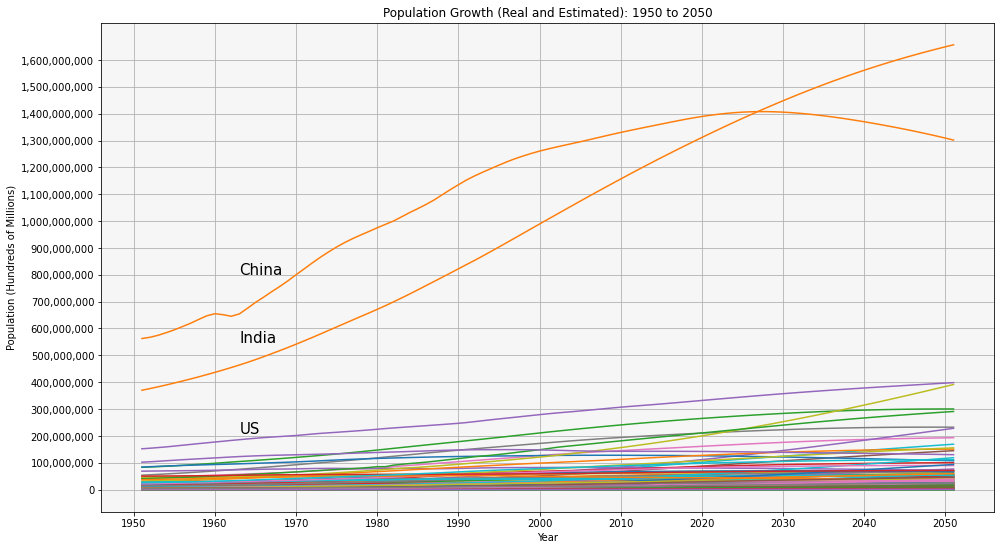

In [5]:
# Look at each country's population 
pop_plot(df)

### Most country population levels are "similar" compared to the top 3 most populous countries

### Let's see how it looks for actual known/experienced time

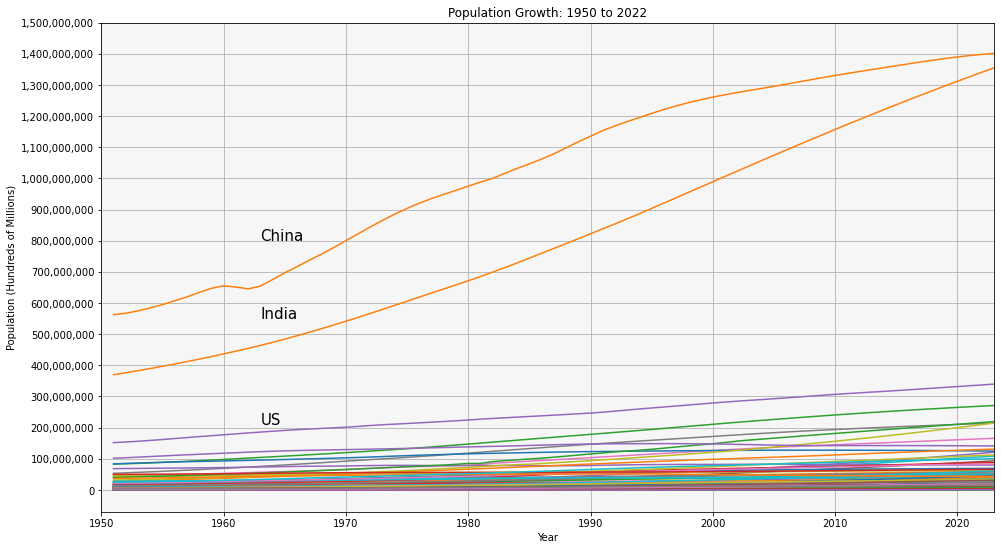

In [6]:
# Over the last 70 years
known(df)

### And now exclude US, China and India to get a better look

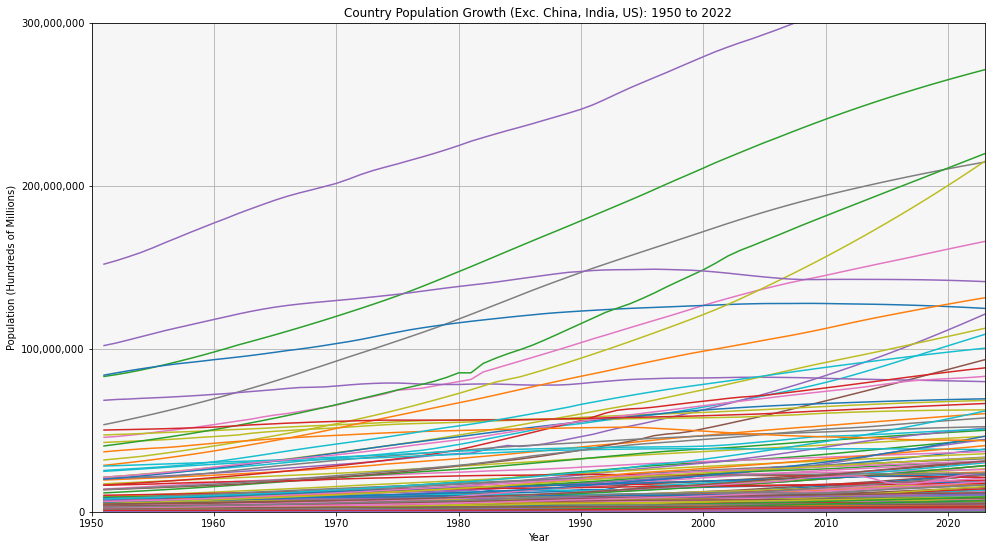

In [7]:
exclude(df)

### Not much more clarification, but we can see that most have population under 100 million people.

# World Population 1950-2050(predicted)

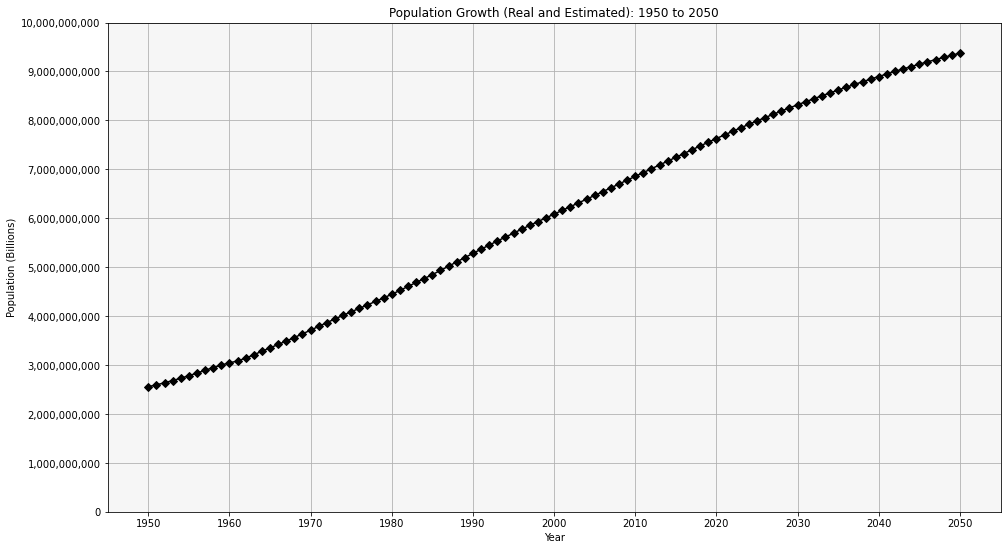

In [8]:
# Worldwide population count.
total_pop(df)

## Computing average growth over time:

In [9]:
%%capture
for i in range(0,73):
    print(((i*72491503)+2557628654), end=',')

In [10]:
y = [2557628654,2630120157,2702611660,2775103163,2847594666,2920086169,2992577672,3065069175,3137560678,3210052181,3282543684,3355035187,3427526690,3500018193,3572509696,3645001199,3717492702,3789984205,3862475708,3934967211,4007458714,4079950217,4152441720,4224933223,4297424726,4369916229,4442407732,4514899235,4587390738,4659882241,4732373744,4804865247,4877356750,4949848253,5022339756,5094831259,5167322762,5239814265,5312305768,5384797271,5457288774,5529780277,5602271780,5674763283,5747254786,5819746289,5892237792,5964729295,6037220798,6109712301,6182203804,6254695307,6327186810,6399678313,6472169816,6544661319,6617152822,6689644325,6762135828,6834627331,6907118834,6979610337,7052101840,7124593343,7197084846,7269576349,7342067852,7414559355,7487050858,7559542361,7632033864,7704525367,7777016870,]
y = pd.DataFrame(y, index=df[df.index < datetime(2023,1,1)].index, columns={'total_population'})

In [11]:
%%capture
for i in range(0,101):
    print(((i*67493619.5)+2557628654), end=',')

In [12]:
w = [2557628654.0,2625122273.5,2692615893.0,2760109512.5,2827603132.0,2895096751.5,2962590371.0,3030083990.5,3097577610.0,3165071229.5,3232564849.0,3300058468.5,3367552088.0,3435045707.5,3502539327.0,3570032946.5,3637526566.0,3705020185.5,3772513805.0,3840007424.5,3907501044.0,3974994663.5,4042488283.0,4109981902.5,4177475522.0,4244969141.5,4312462761.0,4379956380.5,4447450000.0,4514943619.5,4582437239.0,4649930858.5,4717424478.0,4784918097.5,4852411717.0,4919905336.5,4987398956.0,5054892575.5,5122386195.0,5189879814.5,5257373434.0,5324867053.5,5392360673.0,5459854292.5,5527347912.0,5594841531.5,5662335151.0,5729828770.5,5797322390.0,5864816009.5,5932309629.0,5999803248.5,6067296868.0,6134790487.5,6202284107.0,6269777726.5,6337271346.0,6404764965.5,6472258585.0,6539752204.5,6607245824.0,6674739443.5,6742233063.0,6809726682.5,6877220302.0,6944713921.5,7012207541.0,7079701160.5,7147194780.0,7214688399.5,7282182019.0,7349675638.5,7417169258.0,7484662877.5,7552156497.0,7619650116.5,7687143736.0,7754637355.5,7822130975.0,7889624594.5,7957118214.0,8024611833.5,8092105453.0,8159599072.5,8227092692.0,8294586311.5,8362079931.0,8429573550.5,8497067170.0,8564560789.5,8632054409.0,8699548028.5,8767041648.0,8834535267.5,8902028887.0,8969522506.5,9037016126.0,9104509745.5,9172003365.0,9239496984.5,9306990604.0,]
w = pd.DataFrame(w, index=df.index, columns={'total_population'})

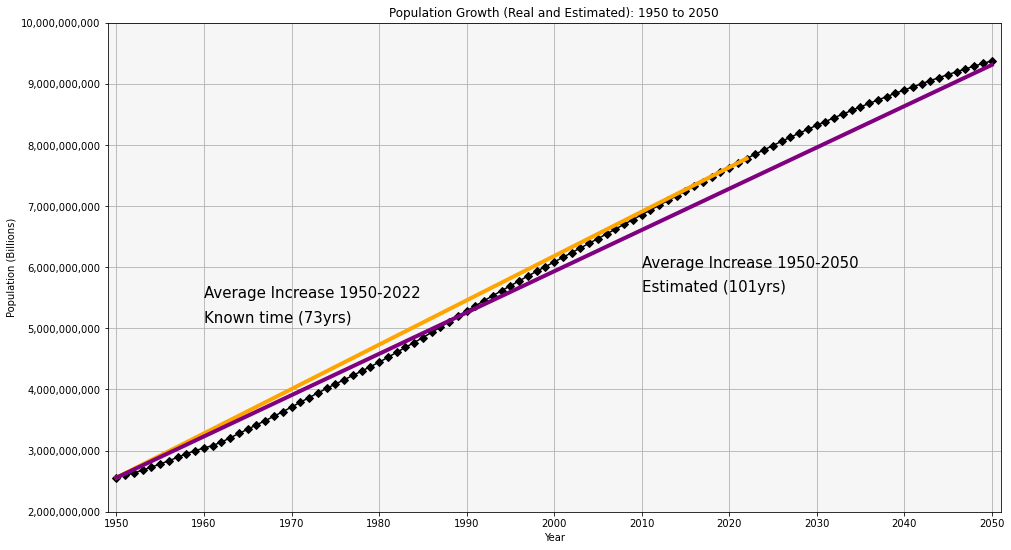

In [13]:
# Plot it
growth(df, y, w)

<div class="alert alert-block alert-success">

# Exploration Findings:
### 1. In the last 70 years, world population has tripled 
### 2. It is estimated to begin to slightly level off starting in 2030, but still almost quadruple by 2050

# Split: Train, Validate, Test

In [14]:
print(f'Train Size: {(len(df) * 0.5)}')
print(f'Validate Size: {(len(df) * 0.3)}')
print(f'Test Size: {(len(df) * 0.2)}')

Train Size: 50.5
Validate Size: 30.299999999999997
Test Size: 20.200000000000003


In [15]:
train = df.iloc[:51]
validate = df.iloc[51:(51+30)]
test = df.iloc[(51+30):]
print(f'Train Shape:     {train.shape}')
print(f'Validate Shape:  {validate.shape}')
print(f'Test Shape:      {test.shape}')

Train Shape:     (51, 229)
Validate Shape:  (30, 229)
Test Shape:      (20, 229)


## Make sure split was done correctly

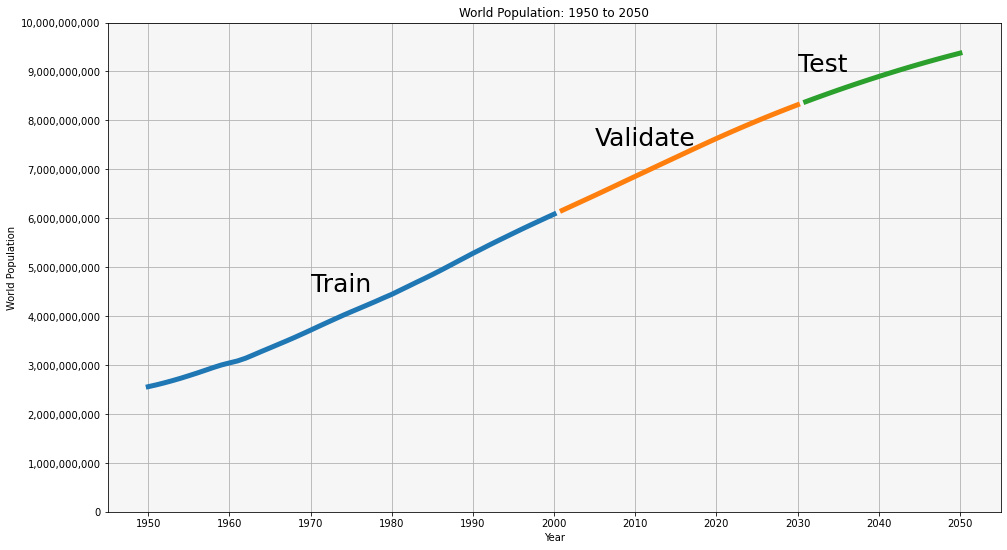

In [16]:
verify_split(train, validate, test)

---

<div class="alert alert-block alert-warning">

# Modeling:

## Predict with last documented population count

In [17]:
pop = train['total_population'][-1:][0]
yhat_df = pd.DataFrame({'total_population': [pop]},index=validate.index)
pred(validate, train['total_population'][-1:][0], 'Last Known')

,total_population
year,
2001-01-01,6084484918
2002-01-01,6084484918


#### Last known value of 6,084,484,918

RMSE: 1353374105.0


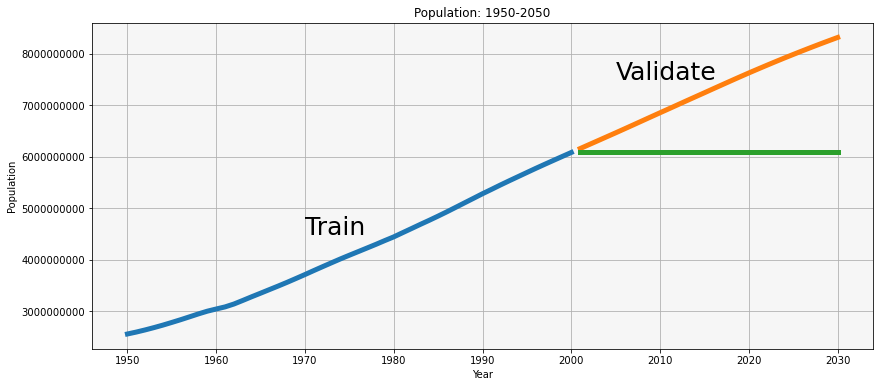

In [18]:
# Plot the Last known population count
plot_eval(train, validate, test, yhat_df, 'total_population')

#### RMSE: 1,353,374,105

___

## Simple Average

In [19]:
# compute simple average
pop = round(train['total_population'].mean(), 2)

# Predict values fo Validate
yhat_df = predictions(validate, pop)

pred(validate, round(train['total_population'].mean(), 2), 'Simple Average')

,total_population
year,
2001-01-01,4.158628e+09
2002-01-01,4.158628e+09


#### Simple Average: 4,158,627,585

RMSE: 3178969281.0


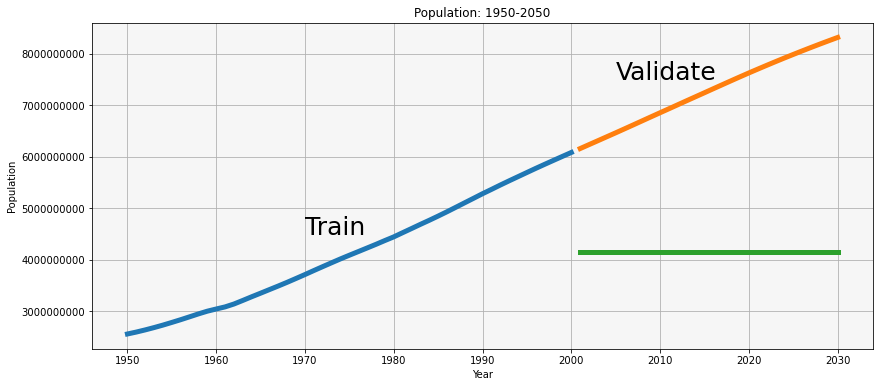

In [20]:
# Plot it
plot_eval(train, validate, test, yhat_df, 'total_population')

---

## Holt's Optimized Model

In [21]:
col = 'total_population' 
# create our Holt's Object
model = Holt(train[col], exponential=True, damped=True)

# fit the holt's object
model = model.fit(optimized=True)

In [22]:
# Predict
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

# Put values into yhat_df
yhat_df[col] = round(yhat_items, 2)
yhat_df.head(3)

,total_population
year,
2001-01-01,6.161363e+09
2002-01-01,6.238422e+09
2003-01-01,6.315659e+09


RMSE: 40746201.0


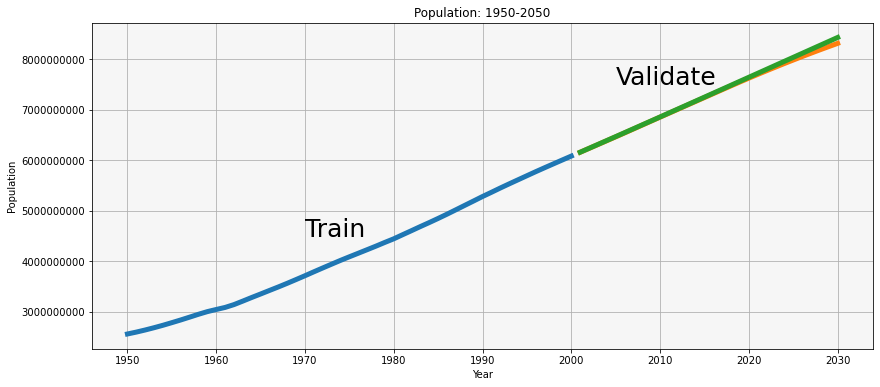

In [23]:
# Plot Validate predictions
plot_eval(train, validate, test, yhat_df, 'total_population')

### RMSE is in the millions vice the billions
#### (40,746,201 vs. Last known at 1,353,374,105)

### Take a closer look as Validate is difficult to distinguish

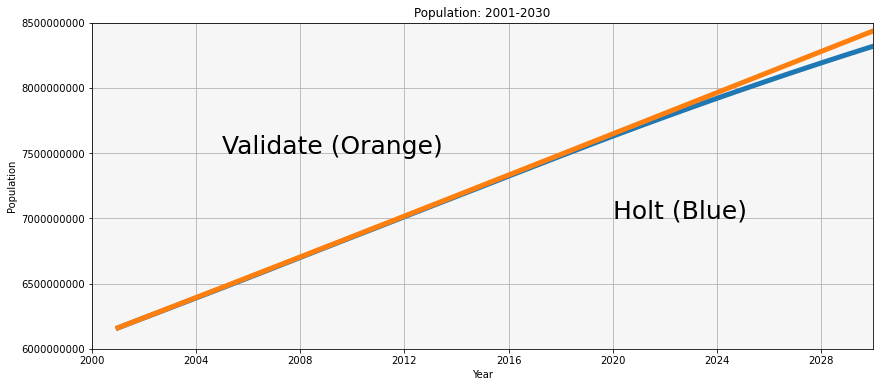

In [24]:
# Focusing just on validate's range
val(validate, yhat_df, 'total_population')

## R2 Score:

In [25]:
explained_variance_score(validate.total_population, yhat_df.total_population)

0.9975750075481733

___

# Test:

In [26]:
# Create df for yhat test predictions
yhat_df = pd.DataFrame(index=test.index, columns=test[['total_population']].columns)

# predict for test
yhat = model.predict(start = test.index[0],
                              end = test.index[-1])
# Put values into yhat_df
yhat_df.total_population = yhat
yhat_df.head(3)

country_name,total_population
year,
2031-01-01,8.515013e+09
2032-01-01,8.593660e+09
2033-01-01,8.672237e+09


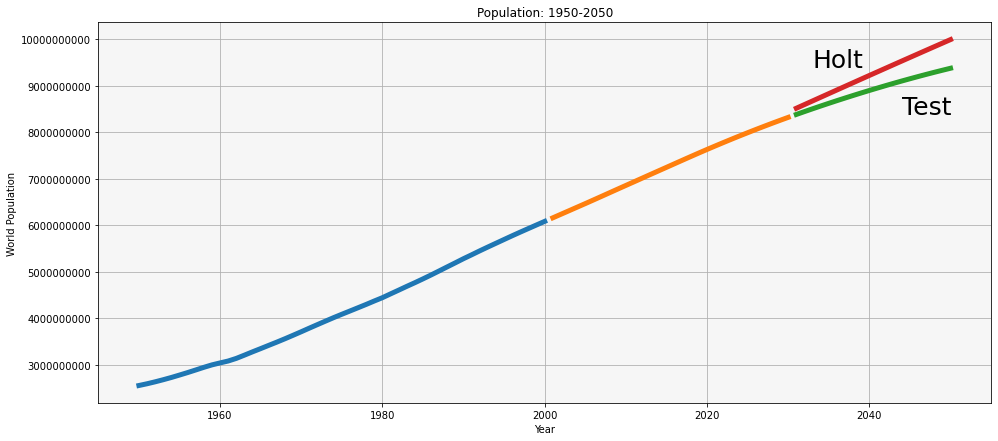

In [27]:
# Plot predictions
plot_all(train, validate, test, yhat_df, 'total_population')

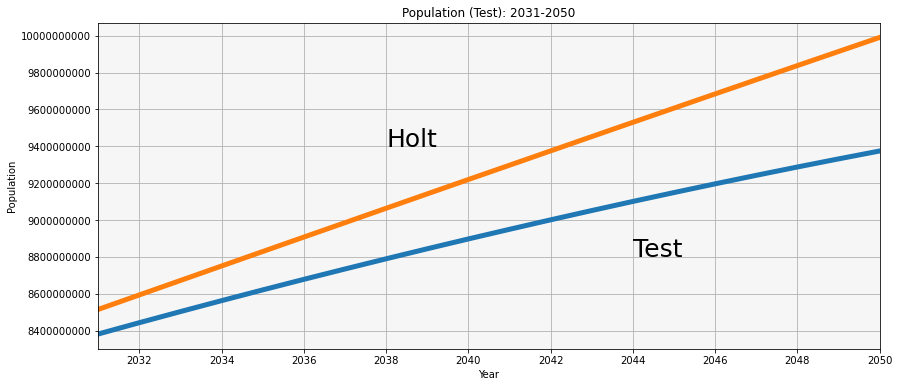

In [28]:
# Focus on Test's range
test_plot(test, yhat_df, 'total_population')

In [29]:
rmse = round(sqrt(mean_squared_error(test['total_population'], yhat_df['total_population'])), 0)
rmse

379245054.0

## RMSE: 
#### 379,245,054

## R2 Score:

In [30]:
explained_variance_score(test.total_population, yhat_df.total_population)

0.76242262030277

---

<div class="alert alert-block alert-success">

# Findings:
### 1. Holt's model doesn't work as well on test as it did on validate
### 2. However, validates data consists of actual population counts (up until 2022), and it can be said the the leveling off that this data has following 2030, is not accurate. There are many factors that come to play, one of them being the lockdowns during the past two years that led to the United States' lowest population growth since the nation was founded.

---

# Recommendations:
### 1. I would continue to use this model for predictions, but would potentially alter metrics to suit beyond 2022 population estimates
### 2. Look at the data prior to 1950 going back 100 years

___

# Additional Steps:
### 1. I'd like to try a regression model based on country crude birth rate, mortality, and life expentancy to see if these results can be replicated using a different model type.